In [192]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [193]:
# #Parameters
# #ndata = 100000 #Number of bits
ndata = int(100000)
Nos = 10 #Number of oversamples

Rb = int(1e9) #Bit rate (Hz)
# fs = Nos * Rb #Sampling frequency (Hz)
# ts = 1/fs # sampling time interval
# Ap = 1 # Amplitude

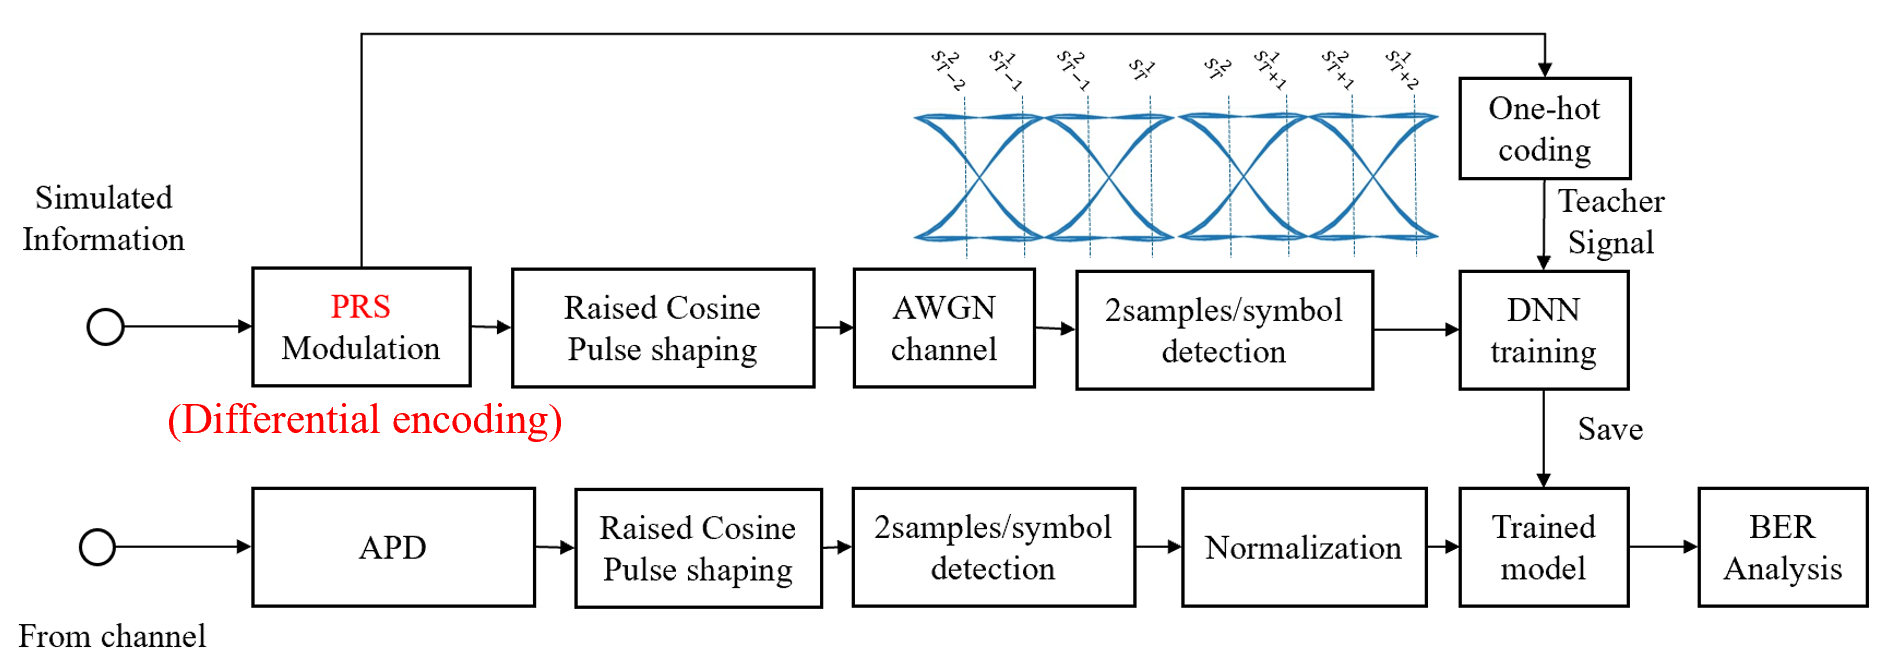

In [194]:
info_data = np.random.randint(2, size=ndata)#A binary sequence of ndata bits, scaled to [0, 1]

In [195]:
def oversampling(sequence, Nos = 10, reverse = False,graph = False):
    '''
        reverse : If is true, when the signal length is even, the signal position will be in the middle and rear part
    '''
    if reverse:
        front = Nos//2;
        behind = (Nos- 1)//2
    else :
        behind = Nos//2;
        front = (Nos - 1)//2

    oversampled = []
    for num in sequence:
        # 前面插入4个0
        oversampled.extend([0] * front)
        # 添加原始码元
        oversampled.append(Nos * num)
        # 后面插入5个0
        oversampled.extend([0] * behind)

    if graph == True:
        plt.stem(oversampled[:200])

    return oversampled
over = oversampling(info_data,graph=False)

升余弦滚降滤波器

In [196]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


def raised_cosine_filter(data,Nos= 10,Rb = 1e9,graph = False):
    """
    生成升余弦滤波器系数
    :param alpha: 滚降因子(0-1)
    :param span: 滤波器符号长度
    :param sps: 每符号采样数
    :return: 滤波器系数
    """
    Nsample = len(data) # Length of the OOK_Imp array 样本长度
    fs = Nos * Rb #Sampling frequency (Hz) 采样频率
    df = fs / Nsample  # Frequency resolution
    # freq = np.linspace(-fs/2, fs/2, Nsample, endpoint=False) # Frequency vector (from -fs/2 to fs/2 with step size df)
    freq = np.arange(-fs / 2, fs / 2, df) # Frequency vector (from -fs/2 to fs/2 with step size df)
    omega = 2 * np.pi * freq # Angular frequency vector (omega = 2 * pi * freq)
    #生成矩形窗函数（频域）

    def myrect_fil(x, bound):
        return np.logical_and(x > -(bound / 2), x < (bound / 2)) 
    #频域乘是升余弦滚降函数，滚降系数为1
    NQ1_RC = (np.cos(omega / (4 * Rb)))**2 * myrect_fil(omega, 4 * np.pi * Rb)

    fftOOK_Imp = np.fft.fftshift(np.fft.fft(data))#对过采样信号进行傅里叶变换
    fftOOK_RC = fftOOK_Imp * NQ1_RC #对信号进行调制

    OOK_RC = np.real(np.fft.ifft(np.fft.ifftshift(fftOOK_RC))) #傅里叶逆变换

    #画图
    if graph == True:
        plt.plot(OOK_RC[:200])
    return OOK_RC

shaped_signal = raised_cosine_filter(over, Nos = Nos, Rb= Rb,graph=False)

In [197]:
def prs_modulation(data,Nos,graph = False):
    '''
    进行prs调制
    '''
    
    o_data = np.pad(data, (0, 1), 'constant')
    d_data = np.pad(data, (1, 0), 'constant')  # 前面加1个0，后面不加


    prs_data = o_data + d_data

    prs_signal = raised_cosine_filter(oversampling(prs_data,graph=False), Nos = Nos, Rb= Rb ,graph=False)
    
    if graph ==True:
        plt.figure(3)
        plt.plot(prs_signal[:200])
        plt.figure(6)
        plt.stem(oversampling(o_data,graph=False)[:200])
        plt.figure(7)
        plt.stem(oversampling(d_data,graph=False)[:200])
    return prs_signal
prs_signal = prs_modulation(info_data,Nos = 10,graph=False)
print(prs_signal.shape)

(1000010,)


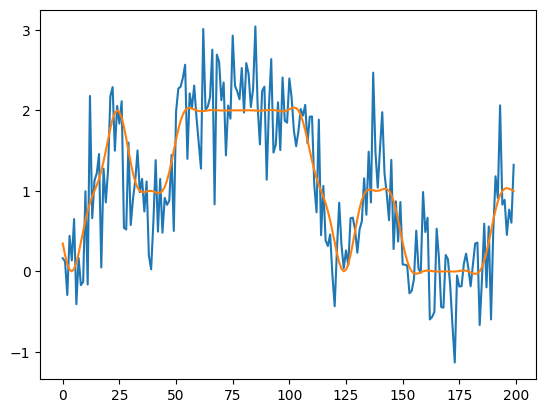

In [198]:
def AWGNGen(signal,EbN0_dB = 5,M = 2,Nos = 10,Rb = 1e9,graph = False, Actual_energy = True,noise_power_comparison = False):  # Function to make AWGN
    siglen = len(signal)
    ndata = siglen/Nos
    # t = np.arange(siglen) * ts
    fs = Nos * Rb #Sampling frequency (Hz) 采样频率
    ts = 1/fs

    if Actual_energy:
        Es = np.sum(signal ** 2) * ts  # Energy of the signal
        Eb = Es / ndata  # Energy per bit
    else:
        #这里没写理论能量
        Es = np.sum(signal ** 2) * ts  # Energy of the signal
        Eb = Es / ndata  # Energy per bit

    EbN0_linear = 10**(EbN0_dB/10)  # dB to linear
    N0 = Eb / EbN0_linear  # Power Spectrum Density
    N = N0 * Rb  # Noise power
    sigma = np.sqrt(N / 2)  # Standard deviation of noise
    noise = sigma * np.random.randn(siglen)  # Generate noise

    if noise_power_comparison:
        noise_power = np.mean(noise**2)  # 应≈N/2
        print(f"理论噪声功率: {N/2}, 实际噪声功率: {noise_power}")

    if graph :
        plt.plot(noise[:200])
    return noise


def awgn_channel(data,EbN0_db = 10,M = 2,Nos = Nos,Rb = Rb,graph = False):
    noisy_signal = AWGNGen(data,EbN0_db,M = M,Nos = Nos,Rb = Rb,graph = False) + prs_signal
    if graph == True :
        plt.plot(noisy_signal[:200])
        plt.plot(data[:200])
    return noisy_signal

noisy_signal = awgn_channel(prs_signal,EbN0_db = 5,M = 2,Nos = Nos,Rb = Rb,graph = True)

(1, 200002)


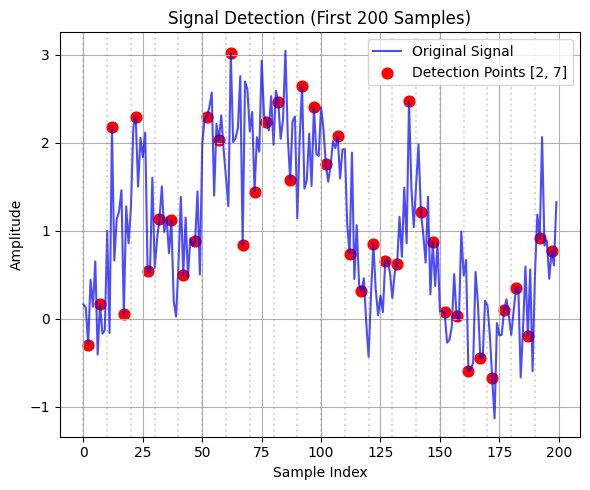

In [199]:
# def detection(data,detect_point,Nos = 10):
#     array = data[detect_point:len(data):Nos]
#     return array


def signal_detection(noisy_data,detection_points = [2,7],graph = False):
    data = np.asarray(noisy_data)
    
    # 计算总符号数
    n_symbols = len(data) // Nos
    
    # 生成所有检测点的全局索引
    indices = np.array(detection_points)[:, None] + Nos * np.arange(n_symbols)
    indices = indices.ravel() 

    result = data[indices].reshape(1, -1)

    if graph :
        plt.figure(figsize=(6, 5))
        
        # 绘制原始信号
        plot_end = min(200, len(data))
        plt.plot(data[:plot_end], 'b-', alpha=0.7, label='Original Signal')
        
        # 标注检测点（在绘图范围内的）
        plot_indices = indices[indices < plot_end]
        plt.scatter(plot_indices, data[plot_indices], 
                    c='red', s=60, marker='o', 
                    label=f'Detection Points {detection_points}')
        
        # 添加符号周期分隔线
        for i in range(0, plot_end, Nos):
            plt.axvline(x=i, color='gray', linestyle=':', alpha=0.3)
        
        # 图表装饰
        plt.title(f'Signal Detection (First {plot_end} Samples)')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

    return result

input_signal = signal_detection(noisy_signal,graph=True)
print(input_signal.shape)



In [200]:
def binary_to_one_hot(binary_matrix):
    # 将每一行的二进制数转换为十进制索引
    indices = binary_matrix[:, 0] * 4 + binary_matrix[:, 1] * 2 + binary_matrix[:, 2] * 1
    
    # 生成独热编码矩阵
    one_hot_encoded = np.eye(8)[indices]  # 8 类独热编码
    
    return one_hot_encoded

利用 6个samples加上前一位以解码单元 一共7位 作为输入循环解码

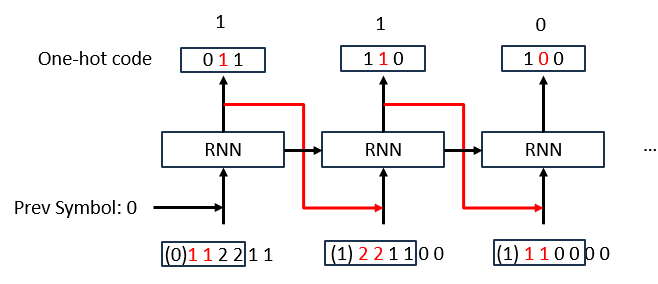

In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def bits_to_int(bits):
    return bits[0]*4 + bits[1]*2 + bits[2]

def int_to_bits(val):
    return [ (val >> 2) & 1, (val >> 1) & 1, val & 1 ]



In [202]:

# 设置随机种子
torch.manual_seed(0)
np.random.seed(0)


# 超参数


# 定义简单的 RNN 模型
class RNN8Class(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes=8,train_model = True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.train_model = train_model
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)  # 8类输出

    def forward(self, x):
        print("x.shape:", x.shape)
        # x 形状: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # 初始化隐藏状态（h0）和 RNN 输出（初始为全零）
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        prev_mid_bit = torch.zeros(batch_size, 1).to(x.device)


        outputs = []

        if self.train_model :
            out, _ = self.rnn(x, h0)
            logits = self.fc(out)  # shape: (batch, seq_len, num_classes)
            return logits  # 可以直接用于 loss 计算
        
        else :
            for t in range(seq_len):
                signal_input = x[:, t, :]  # (batch, 6)
                rnn_input = torch.cat([prev_mid_bit,signal_input], dim=-1).unsqueeze(1) # (batch, 1, 7)
                
                out, h0 = self.rnn(rnn_input, h0)  # (batch, 1, hidden_size)
                logits = self.fc(out.squeeze(1))  # (batch, num_classes)
                outputs.append(logits)

                # 分类预测 -> 3位二进制 -> 取中间bit作为下一个输入
                pred_class = torch.argmax(logits, dim=-1)  # (batch,)
                pred_bits = F.one_hot(pred_class, num_classes=8)  # (batch, 8)
                pred_3bit = ((pred_class[:, None] >> torch.tensor([2, 1, 0]).to(x.device)) & 1).float()  # (batch, 3)
                prev_mid_bit = pred_3bit[:, 1:2]  # 取中间位 (bit[1]) -> shape: (batch, 1)

            
            return torch.stack(outputs, dim=1)



输入训练集

In [203]:

def input_dataset(noisy_signal,data_len, window_size=6, stride=2):
    """
    生成输入数据 (1, seq_len, window_size)
    - noisy_signal: 一维输入信号
    - window_size: 每个子序列长度
    - seq_len: 输出序列长度
    - stride: 滑动步长
    """
    # 计算需要补零的数量（确保非负）
    pad_size = max(0, window_size - stride)
    
    # 确保输入是一维数组
    if len(noisy_signal.shape) > 1:
        noisy_signal = noisy_signal.squeeze()
    
    # 末尾补零
    padded_signal = np.pad(noisy_signal, (0, pad_size), 'constant')
    
    # 生成滑动窗口
    inputs = []
    for i in range(0, data_len * stride, stride):
        if i + window_size > len(padded_signal):
            break  # 防止越界
        window = padded_signal[i:i+window_size]
        inputs.append(window)
    
    # 转换为张量并添加batch维度
    return torch.tensor(inputs, dtype=torch.float32).unsqueeze(0)  # (1, seq_len, window_size)


输入标签集

In [204]:

def teacher_dataset(info_data, data_len, window_size=3):
    """
    生成标签数据 (1, seq_len, 8)
    - 每3个比特构成一个类别（0~7）,标签为one-hot向量
    - 开头和结尾各补一位0
    """
    # 添加首尾0
    padded_data = np.pad(info_data, (1, 1), 'constant')  # 长度增加2

    windows = []
    for i in range(data_len):
        window = padded_data[i:i+window_size]  # 3位滑动窗口
        if len(window) == 3:
            class_id = (window[0] << 2) | (window[1] << 1) | window[2]
            windows.append(class_id)
    
    classes = torch.tensor(windows, dtype=torch.long)
    one_hot = F.one_hot(classes, num_classes=8).float()
    return one_hot.unsqueeze(0)  # shape: (1, seq_len, 8)

In [ ]:

def generate_dataset(info_data, noisy_signal,  ndetect=2, train_model = True):
    """
    生成完整数据集
    - info_data: 真实标签数据
    - noisy_signal: 输入信号
    - seq_len: 序列长度
    - ndetect: 滑动步长
    """
    # 确保输入长度匹配
    data_len = len(info_data)

    
    X_train = input_dataset(noisy_signal,data_len, 6,  stride=ndetect)

    Y_train = teacher_dataset(info_data, data_len, 3)
    print(Y_train)



    if train_model :

        extra_signal = torch.tensor(info_data, dtype=torch.float32)  # shape: (seq_len,)

        # 步骤1：开头加0
        extra_signal_padded = torch.cat([torch.tensor([0.0]), extra_signal[:-1]])  # (seq_len,)

        # 步骤2：变成 shape: (1, seq_len, 1)
        extra_signal_padded = extra_signal_padded.view(1, data_len, 1)

        # 步骤3：拼接到原始信号上
        augmented_signal = torch.cat([extra_signal_padded, X_train], dim=-1)  # (1, seq_len, window_size + 1)

        X_train = augmented_signal


    
    
    # 确保维度匹配
    if X_train.shape[1] != Y_train.shape[1]:
        min_len = min(X_train.shape[1], Y_train.shape[1])
        X_train = X_train[:, :min_len, :]
        Y_train = Y_train[:, :min_len, :]
    
    return X_train, Y_train

X_train, Y_train = generate_dataset(info_data, input_signal, ndetect=2)

In [ ]:
print(X_train)
print(Y_train)

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]]])


In [210]:

window_size = 6
input_size = window_size + 1 #每个时刻数据的维度，这里是一维
hidden_size = 128 #隐藏层大小
num_layers = 2 #层数
num_classes = 8
batch_size = 1
learning_rate = 0.01
num_epochs = 20
seq_len = ndata #时间长度是多少，等于输入信号的序列长度
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





def train_model(model, X_train, Y_train):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 转换为 DataLoader
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # shape: (batch_size, seq_len, num_classes)

            # 打印 one-hot 解码后的输出
            softmax = nn.Softmax(dim=-1)
            print("raw logits:", softmax(outputs)[0, :5].detach().cpu())  # 看前几个序列的logits
            decoded = torch.argmax(outputs, dim=-1)  # (batch_size, seq_len)
            decoded_bits = ((decoded.unsqueeze(-1) >> torch.tensor([2,1,0], device=decoded.device)) & 1)  # shape: (batch_size, seq_len, 3)
            mid_bits = decoded_bits[:, :, 1]# shape: (batch_size, seq_len)
            print(f"Epoch {epoch+1} middle bits output:\n", mid_bits[0].cpu().numpy().tolist())

            # CrossEntropyLoss 要求 inputs: (N, C), targets: (N,C)
            print("label",labels.shape)
            loss = criterion(outputs.view(-1, num_classes), labels.view(-1, num_classes).argmax(dim=1))

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f}')

    # 可选：保存最终模型
    torch.save(model.state_dict(), 'final_model.pth')
    return model


In [211]:
def evaluate_model(model, X, info_data):
    """
    评估模型，计算误码率（BER）
    - model: 训练好的模型
    - X: 输入数据（形状: 1, seq_len, window_size）
    - info_data: 原始信息比特序列（长度: seq_len）
    """

    model.eval()
    with torch.no_grad():
        output = model(X.to(device))  # 输出 shape: (1, seq_len, 8)
        pred_classes = torch.argmax(output, dim=-1)  # (1, seq_len)

        # 转换为3位bit表示，取中间位作为解码比特
        pred_bits = []
        for cls in pred_classes.squeeze(0).cpu().numpy():
            bin_str = format(cls, '03b')  # eg: '010'
            mid_bit = int(bin_str[1])     # 中间位作为输出
            pred_bits.append(mid_bit)

        pred_bits = np.array(pred_bits)

        # info_data: 原始真实比特序列
        info_data = np.array(info_data[:len(pred_bits)])  # 对齐长度

        # 计算误码率
        errors = np.sum(pred_bits != info_data)
        total = len(info_data)
        ber = errors / total

        print(f"预测结果中间位: {pred_bits}")
        print(f"真实信息序列 : {info_data}")
        print(f"误码数: {errors}, 总长度: {total}")
        print(f"误码率 BER: {ber:.4f}")
        
        return ber

In [212]:

# 初始化模型
model = RNN8Class(input_size, hidden_size, num_layers, num_classes).to(device)

# 训练模型
trained_model = train_model(model, X_train, Y_train)
ber = evaluate_model(trained_model, X_train, info_data)
print(ber)

x.shape: torch.Size([1, 100000, 7])
raw logits: tensor([[0.1110, 0.1145, 0.1290, 0.1419, 0.1296, 0.1238, 0.1165, 0.1338],
        [0.1298, 0.1301, 0.1193, 0.1273, 0.1196, 0.1244, 0.1107, 0.1387],
        [0.1152, 0.1162, 0.1223, 0.1416, 0.1272, 0.1395, 0.1057, 0.1322],
        [0.1298, 0.1211, 0.1195, 0.1312, 0.1136, 0.1408, 0.1032, 0.1408],
        [0.1183, 0.1070, 0.1066, 0.1567, 0.1333, 0.1424, 0.0987, 0.1370]])
Epoch 1 middle bits output:
 [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,

TypeError: RNN8Class.forward() got an unexpected keyword argument 'train_model'

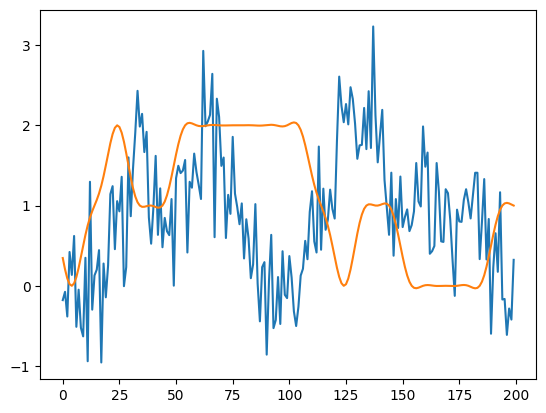

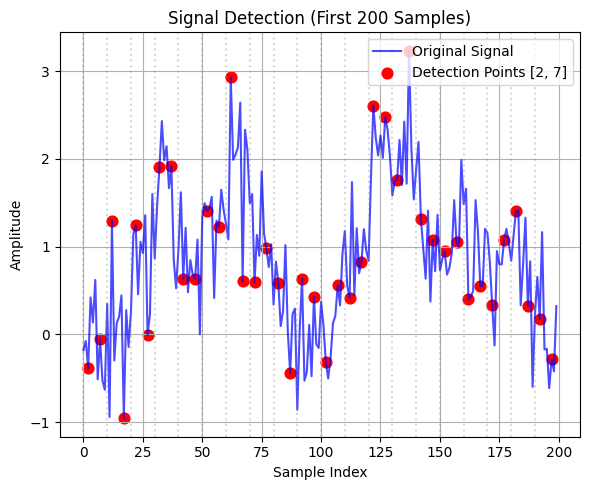

In [69]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()


test_data = np.random.randint(2, size=ndata)#A binary sequence of ndata bits, scaled to [0, 1]
prs_test = prs_modulation(test_data,Nos = 10,graph=False)
noisy_test = awgn_channel(prs_test,EbN0_db = 5,M = 2,Nos = Nos,Rb = Rb,graph = True)
input_test = signal_detection(noisy_test,graph=True)
X_test, Y_test = generate_dataset(test_data, input_test, 2,train_model=False)
with torch.no_grad():
    outputs = model(X_test.to(device),train_model = False)  # (batch, seq_len, num_classes)
    pred = outputs.argmax(dim=-1)       # 取最大概率的类别，形状 (batch, seq_len)

# 还原为3bit二进制
def int_to_bits(val):
    return [(val >> 2) & 1, (val >> 1) & 1, val & 1]

# pred: (batch, seq_len)
batch_size, seq_len = pred.shape
pred_bits = []
for i in range(batch_size):
    bits = [int_to_bits(v.item()) for v in pred[i]]
    pred_bits.append(bits)
pred_bits = np.array(pred_bits).reshape(-1, 3)  # 每行为3bit

# 假设info_data是原始bit序列，长度为ndata，pred_bits是预测的bit序列
# 需要将pred_bits拉平成1维，与info_data对齐
pred_bits_1d = pred_bits.flatten()[:len(info_data)]  # 截断到原始长度
info_data_1d = info_data[:len(pred_bits_1d)]

num_error = np.sum(pred_bits_1d != info_data_1d)
ber = num_error / len(info_data_1d)
print(f"Bit Error Rate (BER): {ber:.6f}")